# A Walk Through Ensemble Models
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. Please check the pdf file for more details.*

In this exercise you will:

- get to know a useful package **pandas** for data analysis/preprocessing
- implement **decision tree** and apply it to a Titanic dataset
- implement a whole bunch of **ensemble methods**, including **random forest, and adaboost**, and apply them to a Titanic dataset

Please note that **YOU CANNOT USE ANY MACHINE LEARNING PACKAGE SUCH AS SKLEARN** for any homework, unless you are asked to.

In [1]:
# some basic imports
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Let's first do some data preprocessing

Here we use [pandas](https://pandas.pydata.org/) to do data preprocessing. Pandas is a very popular and handy package for data science or machine learning. You can also refer to this official guide for pandas: [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)

In [2]:
# read titanic train and test data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

print("train shape: {} test shape: {}".format(train.shape, test.shape))
# Showing overview of the train dataset
train.head(3)

train shape: (1047, 11) test shape: (262, 11)


,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Hays, Miss. Margaret Bechstein",female,24.0,0,0,11767,83.1583,C54,C
1,3,0,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S
2,3,0,"Hansen, Mr. Claus Peter",male,41.0,2,0,350026,14.1083,NaN,S


## deal with missing values and transform to discrete variables

In [3]:
# copied from: https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head()

,Pclass,Survived,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,1,0,1,0,3,1,1,1,1,4
1,3,0,1,2,0,0,0,0,1,1,1
2,3,0,1,2,0,1,0,0,3,0,1
3,3,0,1,1,0,0,2,0,1,1,1
4,2,0,1,2,0,1,0,0,1,1,1


One of the good thing of pd.DataFrame is that you can keep the column names along with the data, which can be beneficial for many case.

Another good thing is that pd.DataFrame can be converted to np.array implicitely.

Also, pd provides a lot of useful data manipulating methods for your convenience, though we may not use them in this homework.

In [6]:
X = train.drop(['Survived'], axis=1)
y = train["Survived"]
X_test = test.drop(['Survived'], axis=1)
y_test = test["Survived"]
print("train: {}, test: {}".format(X.shape, X_test.shape))

train: (1047, 10), test: (262, 10)


In [7]:
def accuracy(y_gt, y_pred):
    return np.sum(y_gt == y_pred) / y_gt.shape[0]

In [8]:
print("Survived: {:.4f}, Not Survivied: {:.4f}".format(y.sum() / len(y), 1 - y.sum() / len(y)))

Survived: 0.3878, Not Survivied: 0.6122


## Decision Tree
Now it's your turn to do some real coding. Please implement the decision tree model in **decision_tree.py**. The PDF file provides some hints for this part.

Accuracy on train set: 0.8233046800382043


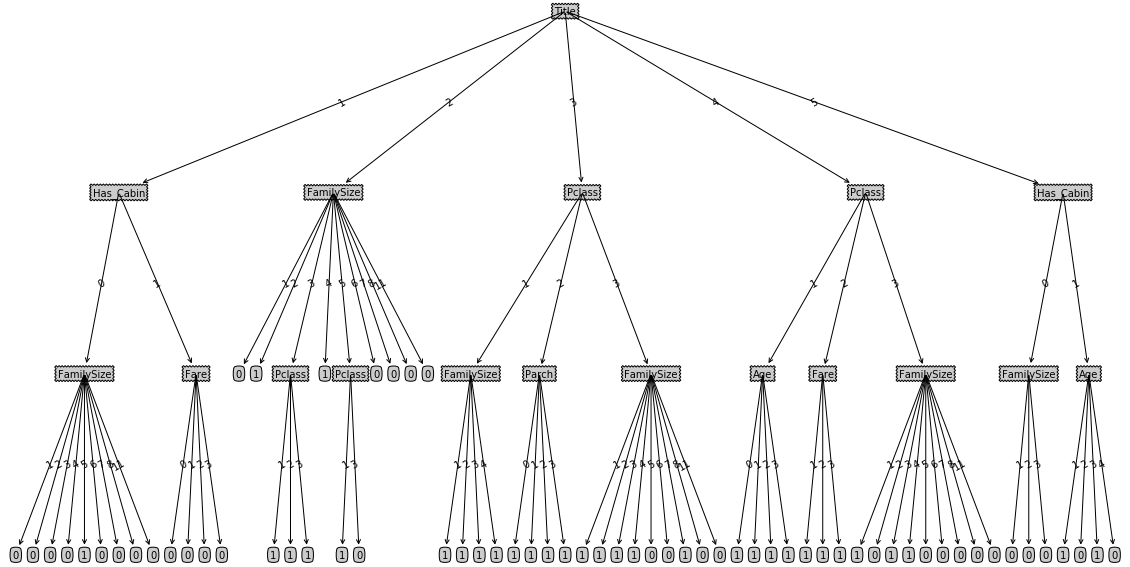

In [9]:
from decision_tree import DecisionTree

dt = DecisionTree(criterion='entropy', max_depth=4, min_samples_leaf=2, sample_feature=False)
dt.fit(X, y)

y_train_pred = dt.predict(X)
print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

# Plot the decision tree to get an intuition about how it makes decision
plt.figure(figsize=(20, 10))
dt.show()

In [39]:
# TODO: Train the best DecisionTree(best val accuracy) that you can. You should choose some 
# hyper-parameters such as critertion, max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# To reduce difficulty, you can use KFold here.
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
criters = ['infogain_ratio', 'entropy', 'gini']
best_criter = criters[0]
best_depth = 3
best_leaves = 2
best_accuracy = 0.0

for depth in range(3, 9):
    for leaves in range(1, 10):
        for criter in criters:
            dt = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaves, sample_feature=False)
            predict = np.zeros(len(X))
            for train_indice, valid_indice in kf.split(X, y):
                X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                dt.fit(X_train_fold, y_train_fold)
                predict[valid_indice] = dt.predict(X_val_fold)
            accuracy_now = accuracy(y, predict)
            if accuracy_now > best_accuracy:
                best_criter = criter
                best_depth = depth
                best_leaves = leaves
                best_accuracy = accuracy_now
print("best_criter: {}, best_depth: {}, best_leaves: {}".format(best_criter, best_depth, best_leaves))

# begin answer
print("Training error rate: {}".format(1 - accuracy(y, dt.predict(X))))
print("Validation error rate: {}".format(1 - best_accuracy))
# end answer

best_criter: infogain_ratio, best_depth: 4, best_leaves: 1
Training error rate: 0.16714422158548237
Validation error rate: 0.19102196752626555


In [40]:
# report the accuracy on test set
dt = DecisionTree(criterion = best_criter, max_depth = best_depth, min_samples_leaf = best_leaves, sample_feature = False)
dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, dt.predict(X_test))))

Accuracy on train set: 0.8127984718242598
Accuracy on test set: 0.7900763358778626


## Random Forest
Please implement the random forest model in **random_forest.py**. The PDF file provides some hints for this part.

In [11]:
from random_forest import RandomForest

base_learner = DecisionTree(criterion='entropy', max_depth=4, min_samples_leaf=2, sample_feature=True)
rf = RandomForest(base_learner=base_learner, n_estimator=10, seed=2020)
rf.fit(X, y)

y_train_pred = rf.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.7851002865329513


In [12]:
# TODO: Train the best RandomForest that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
criters = ['infogain_ratio', 'entropy', 'gini']
estimators = [10, 100]
best_criter = criters[0]
best_estimator = estimators[0]
best_depth = 3
best_leaves = 2
best_accuracy = 0.0

for n_estimator in estimators:
    temp_accuracy = 0.0
    for depth in range(4, 8):
        for leaves in range(1, 5):
            for criter in criters:
                base_learner = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaves, sample_feature=True)
                rf = RandomForest(base_learner=base_learner, n_estimator=n_estimator, seed=2020)
                predict = np.zeros(len(X))
                for train_indice, valid_indice in kf.split(X, y):
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    rf.fit(X_train_fold, y_train_fold)
                    predict[valid_indice] = rf.predict(X_val_fold)
                accuracy_now = accuracy(y, predict)
                if accuracy_now > temp_accuracy:
                    temp_criter = criter
                    temp_estimator = n_estimator
                    temp_depth = depth
                    temp_leaves = leaves
                    temp_accuracy = accuracy_now
    print("temp_estimator: {}, temp_criter: {}, temp_depth: {}, temp_leaves: {}".format(temp_estimator, temp_criter, temp_depth, temp_leaves))
    print("Training error rate: {}".format(1 - accuracy(y, rf.predict(X))))
    print("Validation error rate: {}".format(1 - temp_accuracy))
    if(temp_accuracy > best_accuracy):
        best_criter = temp_criter
        best_estimator = temp_estimator
        best_depth = temp_depth
        best_leaves = temp_leaves
        best_accuracy = temp_accuracy

print("best_estimator: {}, best_criter: {}, best_depth: {}, best_leaves: {}".format(best_estimator, best_criter, best_depth, best_leaves))

temp_estimator: 10, temp_criter: entropy, temp_depth: 7, temp_leaves: 3
Training error rate: 0.1614135625596944
Validation error rate: 0.20248328557784145
temp_estimator: 100, temp_criter: entropy, temp_depth: 7, temp_leaves: 4
Training error rate: 0.15090735434574976
Validation error rate: 0.19866284622731611
best_estimator: 100, best_criter: entropy, best_depth: 7, best_leaves: 4


In [13]:
# report the accuracy on test set
# begin answer
base_learner = DecisionTree(criterion = best_criter, max_depth = best_depth, min_samples_leaf = best_leaves, sample_feature = True)
rf = RandomForest(base_learner = base_learner, n_estimator = best_estimator, seed = 2020)
# end answer
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))

Accuracy on train set: 0.8519579751671442
Accuracy on test set: 0.8015267175572519


In [23]:
print("Random Forest")
base_learner = DecisionTree(criterion = "infogain_ratio", max_depth = 4, min_samples_leaf = 1, sample_feature = True)
rf = RandomForest(base_learner = base_learner, n_estimator = 100, seed = 2020)
rf.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, rf.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, rf.predict(X_test))))
print("Decision Tree")
dt = DecisionTree(criterion = "infogain_ratio", max_depth = 4, min_samples_leaf = 1, sample_feature = False)
dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, dt.predict(X_test))))

Random Forest
Accuracy on train set: 0.8061127029608405
Accuracy on test set: 0.8053435114503816
Decision Tree
Accuracy on train set: 0.8127984718242598
Accuracy on test set: 0.7900763358778626


## Adaboost
Please implement the adaboost model in **adaboost.py**. The PDF file provides some hints for this part.

In [10]:
from adaboost import Adaboost

base_learner = DecisionTree(criterion='entropy', max_depth=4, min_samples_leaf=1, sample_feature=False)
ada = Adaboost(base_learner=base_learner, n_estimator=50, seed=2020)
ada.fit(X, y)

y_train_pred = ada.predict(X)

print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))

Accuracy on train set: 0.8319006685768864


In [11]:
# TODO: Train the best Adaboost that you can. You should choose some 
# hyper-parameters such as max_depth, and min_samples_in_leaf 
# according to the cross-validation result.
# begin answer
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)
criters = ['infogain_ratio', 'entropy', 'gini']
estimators = [10, 100]
best_criter = criters[0]
best_estimator = estimators[0]
best_depth = 3
best_leaves = 2
best_accuracy = 0.0

for n_estimator in estimators:
    temp_accuracy = 0.0
    for depth in range(2, 5):
        for leaves in range(1, 4):
            for criter in criters:
                base_learner = DecisionTree(criterion=criter, max_depth=depth, min_samples_leaf=leaves, sample_feature=False)
                ada = Adaboost(base_learner=base_learner, n_estimator=n_estimator, seed=2020)
                predict = np.zeros(len(X))
                for train_indice, valid_indice in kf.split(X, y):
                    X_train_fold, y_train_fold = X.loc[train_indice], y.loc[train_indice]
                    X_val_fold, y_val_fold = X.loc[valid_indice], y.loc[valid_indice]
                    ada.fit(X_train_fold, y_train_fold)
                    predict[valid_indice] = ada.predict(X_val_fold)
                accuracy_now = accuracy(y, predict)
                if accuracy_now > temp_accuracy:
                    temp_criter = criter
                    temp_estimator = n_estimator
                    temp_depth = depth
                    temp_leaves = leaves
                    temp_accuracy = accuracy_now
        print(temp_accuracy)
    print("temp_estimator: {}, temp_criter: {}, temp_depth: {}, temp_leaves: {}".format(temp_estimator, temp_criter, temp_depth, temp_leaves))
    print("Training error rate: {}".format(1 - accuracy(y, ada.predict(X))))
    print("Validation error rate: {}".format(1 - temp_accuracy))
    if(temp_accuracy > best_accuracy):
        best_criter = temp_criter
        best_estimator = temp_estimator
        best_depth = temp_depth
        best_leaves = temp_leaves
        best_accuracy = temp_accuracy

print("best_estimator: {}, best_criter: {}, best_depth: {}, best_leaves: {}".format(best_estimator, best_criter, best_depth, best_leaves))
# end answer

0.7621776504297995
0.7984718242597899
0.7984718242597899
temp_estimator: 10, temp_criter: gini, temp_depth: 3, temp_leaves: 1
Training error rate: 0.17000955109837634
Validation error rate: 0.2015281757402101
0.7621776504297995
0.7984718242597899
0.7984718242597899
temp_estimator: 100, temp_criter: gini, temp_depth: 3, temp_leaves: 1
Training error rate: 0.1709646609360076
Validation error rate: 0.2015281757402101
best_estimator: 10, best_criter: gini, best_depth: 3, best_leaves: 1


In [12]:
# report the accuracy on test set
# begin answer
base_learner = DecisionTree(criterion = best_criter, max_depth = best_depth, min_samples_leaf = best_leaves, sample_feature = False)
ada = Adaboost(base_learner = base_learner, n_estimator = best_estimator, seed = 2020)
# end answer
ada.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, ada.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, ada.predict(X_test))))

Accuracy on train set: 0.8127984718242598
Accuracy on test set: 0.8129770992366412


In [30]:
print("Adaboost")
base_learner = DecisionTree(criterion = "gini", max_depth = 3, min_samples_leaf = 1, sample_feature = False)
ada = Adaboost(base_learner = base_learner, n_estimator = 10, seed = 2020)
ada.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, ada.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, ada.predict(X_test))))
print("Decision Tree")
dt = DecisionTree(criterion = "infogain_ratio", max_depth = 4, min_samples_leaf = 1, sample_feature = False)
dt.fit(X, y)
print("Accuracy on train set: {}".format(accuracy(y, dt.predict(X))))
print("Accuracy on test set: {}".format(accuracy(y_test, dt.predict(X_test))))

Adaboost
Accuracy on train set: 0.8127984718242598
Accuracy on test set: 0.8129770992366412
Decision Tree
Accuracy on train set: 0.8127984718242598
Accuracy on test set: 0.7900763358778626


## Comparsion
Report the result of all learned classiers like: naive bayes, perception, logistic regression, SVM, neural network, KNN, decision tree, random forest, adaboost (It is better to use your own implementation, or you can use sklearn here). And state their advantages and disadvantages.

In [41]:
# https://scikit-learn.org/stable/modules/classes.html
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

print("navie bayes:")
naive_bayes = GaussianNB()
print(cross_val_score(naive_bayes, X, y, cv = 3).mean())

print("perceptron:")
perceptron = Perceptron()
print(cross_val_score(perceptron, X, y, cv = 3).mean())

print("logistic regression:")
logistic_regression = LogisticRegression(C = 1)
print(cross_val_score(logistic_regression, X, y, cv = 3).mean())

print("SVM:")
svm = SVC(C = 1, kernel = 'rbf', gamma = 1)
print(cross_val_score(svm, X, y, cv = 3).mean())

print("neural network:")
neural_network = MLPClassifier(activation='relu', alpha=0.0001, max_iter = 1000)
print(cross_val_score(neural_network, X, y, cv = 3).mean())

print("KNN:")
knn = KNeighborsClassifier(n_neighbors = 5)
print(cross_val_score(knn, X, y, cv = 3).mean())

print("decision tree:")
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X, y)
print(decision_tree.score(X_test, y_test))

print("random forest:")
random_forest = RandomForestClassifier(n_estimators = 100)
print(cross_val_score(random_forest, X, y, cv = 3).mean())

print("adaboost:")
adaboost = AdaBoostClassifier(n_estimators = 100)
print(cross_val_score(adaboost, X, y, cv = 3).mean())

navie bayes:
0.7621776504297993
perceptron:
0.7039159503342884
logistic regression:
0.7803247373447947
SVM:
0.7774594078319007
neural network:
0.7831900668576885
KNN:
0.7793696275071632
decision tree:
0.8091603053435115
random forest:
0.7765042979942693
adaboost:
0.8022922636103152


## Parallel random forest

In [13]:
from random_forest import RandomForest
from decision_tree import DecisionTree
from multiprocessing import Pool
import time
import parallel
    
if __name__ == '__main__':
    n_estimator = 100
    
    startTime1 = time.time()
    base_learner = DecisionTree(criterion='entropy', max_depth=4, min_samples_leaf=2, sample_feature=True)
    rf = RandomForest(base_learner=base_learner, n_estimator=n_estimator, seed=2020)
    rf.fit(X, y)
    y_train_pred = rf.predict(X)
    
    print("Accuracy on train set: {}".format(accuracy(y, y_train_pred)))
    endTime1 = time.time()
    print("time cost without parallel: {}".format(endTime1 - startTime1))
    
    startTime2 = time.time()
    pool = Pool(5)
    res = []
    for i in range(n_estimator):
        idx = np.random.choice(X.shape[0], X.shape[0], replace = True)
        factors = [(X, y)]
        res.append(pool.apply_async(parallel.temp, factors))
    pool.close()
    pool.join()
    
    prediction = [result.get() for result in res]
    prob = []
    label = np.unique(y[:, ])
    for i in label:
        prob.append((np.array(prediction) == i).mean(axis = 0))

    y_pred = label[np.argmax(np.array(prob).T, axis = 1)]
    print("Accuracy on train set: {}".format(accuracy(y, y_pred)))
    
    endTime2 = time.time()
    print("time cost with parallel: {}".format(endTime2 - startTime2))

Accuracy on train set: 0.8089780324737345
time cost without parallel: 34.71803951263428
Accuracy on train set: 0.8070678127984718
time cost with parallel: 11.858999490737915


##  Implement GBDT (Gradient Boosting Decision Tree)